<br><br><br><br><br>

# Accelerating Python

<br><br><br><br><br>

<br><br><br><br><br>

### 1. Vertical scaling (making a single thread faster)

<br><br><br><br><br>

<br>

<p style="font-size: 1.25em">Apart from clever algorithms, the speed of a program is determined by how laden it is with work unrelated to its main task.</p>

<center><img src="img/swallows-coconut.jpg" width="50%"></center>

<p style="font-size: 1.25em">Python is slower than C because of dynamic type checking, garbage collection, everything-is-a-hashtable, pointer chasing, string equality checks...</p>

<br>

<p style="font-size: 1.25em">Compare to Java, which has garbage collection but not dynamic type checking, and C, which has neither (on a variety of benchmark algorithms).</p>

<img src="img/benchmark-games.png" width="100%">

<br><br>

<p style="font-size: 1.25em">If you care about speed <i>more than</i> ease of development, use C or C++ (or Rust!).</p>

<br>

<p style="font-size: 1.25em">If you want to use Python for all of its conveniences—dynamic type checking, garbage collection, everything-is-a-hashtable, interactive development and debugging—and need to speed up a critical section, there are ways to do it.</p>

<br>

<p style="font-size: 1.25em">But you have to give up Python's dynamism <i>in that section.</i></p>

<br><br>

In [1]:
# Some wacky things you can do to types and objects in Python:
class Point:
    def __init__(self, x, y):
        self.x, self.y = x, y
p = Point(1, 2)

# dynamically add an attribute to an instance (attributes are really a hashtable)
p.z = 3

# dynamically add a method to a class (class is a hashtable of functions)
Point.mag2 = lambda self: self.x**2 + self.y**2 + self.z**2
p.mag2()

# dynamically add a method to an instance (differs only in assigning "self")
p.mag = (lambda self: self.mag2()**0.5).__get__(p)
p.mag()

class Pointy(Point):
    def __repr__(self):
        return "Pointy({0}, {1})".format(self.x, self.y)

# dynamically change the class of an object (type is just an attribute)
p.__class__ = Pointy
p

Pointy(1, 2)

In [2]:
# That's because in Python, this:

print()
print(Point(1, 2))

# is not fundamentally different from this:

print()
print({"x": 1, "y": 2})

# as you can see by this:

print()
print(Point(1, 2).__dict__)



{'x': 1, 'y': 2}

{'x': 1, 'y': 2}


<br><br>

<p style="font-size: 1.25em">As a statically compiled program, Python has only one data type, <tt>PyObject*</tt> with a pointer to its runtime type, which is yet another <tt>PyObject*</tt>.</p>

<center><img src="img/pyobject.png" width="50%"></center>

<p style="font-size: 1.25em">That gives us the flexibility to do all the wacky things on the previous slide, but at a runtime cost of checking those types <i>every time they are used.</i></p>

<br><br>

In [3]:
# x is an integer
x = 0

for i in range(1000000):
    # in the millionth step, replace x with a string
    if i == 999999:
        x = "hello"
    # do an operation on x that only works for integers
    x += 1

TypeError: can only concatenate str (not "int") to str

In [4]:
import numba

@numba.jit(nopython=True)
def f():
    x = 0
    for i in range(1000000):
        # in the millionth step, replace x with a string
        if i == 999999:
            x = "hello"
        # do an operation on x that only works for integers
        x += 1
    return x

f()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Cannot unify int64 and Literal[str](hello) for 'x', defined at <ipython-input-4-290cb8971149> (5)

File "<ipython-input-4-290cb8971149>", line 5:
def f():
    x = 0
    ^

[1] During: typing of assignment at <ipython-input-4-290cb8971149> (9)

File "<ipython-input-4-290cb8971149>", line 9:
def f():
    <source elided>
        if i == 999999:
            x = "hello"
            ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [6]:
import ROOT

ROOT.gInterpreter.Declare("""
int f() {
    int x = 0;
    for (int i = 0; i < 1000000; i++) {
        // in the millionth step, replace x with a string
        if (i == 999999) {
            x = "hello";
        }
        // do an operation on x that only works for integers
        x += 1;
    }
    return x;
}""")

ROOT.f()

AttributeError: f

input_line_33:7:17: error: assigning to 'int' from incompatible type 'const char [6]'
            x = "hello";
                ^~~~~~~


<br><br><br>

<p style="font-size: 1.25em">My unsurprising, conventional answer to <b>"how do I make it fast?"</b></p>

<ol>
    <li style="font-size: 1.25em; margin-bottom: 0.75em">Determine all data types statically: i.e. one variable ↔ one type and all values in a list/array have the same type.
    <li style="font-size: 1.25em">Take advantage of the static types by converting the program into machine code: i.e. verify those types and generate code without runtime type-checks.
</ol>

<br>

<p style="font-size: 1.25em; text-align: center"><b>We usually call this "compiling."</b></p>

<br><br><br>

<br><br><br>

<p style="font-size: 1.25em"><b>But:</b> "compiling" does not necessarily mean "rewrite in C or C++."</p>

<ul>
    <li style="font-size: 1.25em; margin-bottom: 0.75em">Any language can be compiled.
    <li style="font-size: 1.25em; margin-bottom: 0.75em">Compilation does not need to be a separate phase from running the program.
    <li style="font-size: 1.25em; margin-bottom: 0.75em">The compiled section can be as little or as much as you want.
    <li style="font-size: 1.25em; margin-bottom: 0.75em">If you're using Python to organize your analysis, focus only on the part that needs to be fast. <i>Which part scales with the number of events?</i>
</ul>

<br><br><br>

<br><br><br>

<center><img src="img/numba-logo.png" width="25%"></center>

<br>

<p style="font-size: 1.25em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px">Numba is a just-in-time compiler of Python code.</p>

<br><br><br>

In [7]:
import numpy

@numba.jit(nopython=True)
def mag(xarray, yarray):
    out = numpy.empty(min(len(xarray), len(yarray)))
    
    for i in range(len(out)):
        out[i] = numpy.sqrt(xarray[i]**2 + yarray[i]**2)
    
    return out

mag

CPUDispatcher(<function mag at 0x7a9b4c48ff28>)

In [8]:
a = numpy.arange(1000000, dtype=numpy.int32)
b = numpy.arange(1000000, dtype=numpy.int64)

gap = ",\n                        "
print(f"mag.overloads.keys() = [{gap.join(str(x) for x in mag.overloads.keys())}]")
print(f"\nmag(a, a).sum()      = {mag(a, a).sum()}")
print(f"mag.overloads.keys() = [{gap.join(str(x) for x in mag.overloads.keys())}]")
print(f"\nmag(a, b).sum()      = {mag(a, b).sum()}")
print(f"mag.overloads.keys() = [{gap.join(str(x) for x in mag.overloads.keys())}]")
print(f"\nmag(b, b).sum()      = {mag(b, b).sum()}")
print(f"mag.overloads.keys() = [{gap.join(str(x) for x in mag.overloads.keys())}]")

mag.overloads.keys() = []

mag(a, a).sum()      = 707106074079.7664
mag.overloads.keys() = [(array(int32, 1d, C), array(int32, 1d, C))]

mag(a, b).sum()      = 707106074079.7664
mag.overloads.keys() = [(array(int32, 1d, C), array(int32, 1d, C)),
                        (array(int32, 1d, C), array(int64, 1d, C))]

mag(b, b).sum()      = 707106074079.7664
mag.overloads.keys() = [(array(int32, 1d, C), array(int32, 1d, C)),
                        (array(int32, 1d, C), array(int64, 1d, C)),
                        (array(int64, 1d, C), array(int64, 1d, C))]


<br><br><br>

<p style="font-size: 1.25em">Numba compiles a <a href="https://numba.pydata.org/numba-doc/dev/reference/pysupported.html" target="_blank">subset of the Python language</a> and a <a href="https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html" target="_blank">subset of Numpy functions</a> to machine code (through LLVM).</p>

<br>

<p style="font-size: 1.25em">It also sets up conversions between Python/Numpy and the compiled code.</p>

<br>

<p style="font-size: 1.25em">A good way to use it: develop in Python because it's easy, eliminate dynamic features from the part that needs to be fast, and try <tt>@numba.jit</tt> until successful.</p>

<br><br><br>

In [9]:
# Numba has a particular affinity for Numpy (and an unfortunate name).
#
# Most of the type declarations (int this, float that) come from Numpy dtypes.

# numba.vectorize lets you define a Numpy ufunc from a scalars → scalar function:
@numba.vectorize
def mag(x, y):
    return numpy.sqrt(x**2 + y**2)

mag(a, b)

array([0.00000000e+00, 1.41421356e+00, 2.82842712e+00, ...,
       1.41420932e+06, 1.41421073e+06, 1.41421215e+06])

In [10]:
# Given a signature, it can even compile Python into a pure C function
# (accessible via a function pointer).

@numba.cfunc(numba.float64(numba.int32, numba.int32))
def mag(x, y):
    return numpy.sqrt(x**2 + y**2)

mag, mag.address

(<Numba C callback 'mag'>, 134806474793008)

<br><br><br><br>

<center><img src="img/root-logo.png" width="50%"></center>

<br>

<p style="font-size: 1.25em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px">ROOT does many things, but one of them is <i>automatically</i> binding C++ to Python.</p>

<br><br><br><br>

In [11]:
%%cpp -d

//# Of course, you can also write the part that needs to be fast in C++.

void mag(int n, double* xarray, double* yarray, double* out) {
    for (int i = 0; i < n; i++) {
        out[i] = sqrt(xarray[i]*xarray[i] + yarray[i]*yarray[i]);
    }
}

In [12]:
xarray = numpy.arange(1000000, dtype=numpy.float64)
yarray = numpy.arange(1000000, dtype=numpy.float64)
out = numpy.empty(1000000, dtype=numpy.float64)

ROOT.mag(len(out), xarray, yarray, out)

out

array([0.00000000e+00, 1.41421356e+00, 2.82842712e+00, ...,
       1.41420932e+06, 1.41421073e+06, 1.41421215e+06])

<br><br><br>

<p style="font-size: 1.25em">After you <tt>import ROOT</tt>,</p>

<ul>
    <li style="font-size: 1.25em"><tt>%%cpp</tt> at the top of a Jupyter cell evaluates as a line of C++ ROOT,
    <li style="font-size: 1.25em"><tt>%%cpp -d</tt> at the top of a Jupyter cell defines a C++ function,
    <li style="font-size: 1.25em"><tt>ROOT.gInterpreter.ProcessLine</tt> in Python evaluates a line of C++ ROOT,
    <li style="font-size: 1.25em"><tt>ROOT.gInterpreter.Declare</tt> in Python defines a C++ function,
</ul>

<p style="font-size: 1.25em">and PyROOT lets you call C++ functions from Python.</p>

<br><br><br>

<br>

<img src="img/03-cheat-sheet.png" width="100%">

<br>

In [14]:
# You can't redefine C++ functions, which makes interactive work difficult.





ROOT.gInterpreter.Declare(r"""

    double cpp_func(double x) {
        return x*x;
    }

""")
cpp_func = ROOT.cpp_func

cpp_func(5)

25.0

input_line_38:3:12: error: redefinition of 'cpp_func'
    double cpp_func(double x) {
           ^
input_line_36:3:12: note: previous definition is here
    double cpp_func(double x) {
           ^


In [15]:
# You can't redefine C++ functions, which makes interactive work difficult.
# 
# Here's a way to make a redefinable function:

pyname = "cpp_func"
cppname = pyname + "_%d" % sum(1 if x.startswith(pyname) else 0 for x in dir(ROOT))
ROOT.gInterpreter.Declare(r"""

    double """ + cppname + r"""(double x) {
        return x*x;
    }

""")
exec(f"{pyname} = ROOT.{cppname}")

cpp_func(5)

25.0

In [17]:
# Also, you need to be very careful about data types because ROOT does not
# read them off of Numpy arrays.

if not hasattr(ROOT, "assumes_double"):
    ROOT.gInterpreter.Declare("""
void assumes_double(int n, double* xarray, double* out) {
    for (int i = 0; i < n; i++) {
        out[i] = xarray[i]*xarray[i];
    }
}
""")

xarray = numpy.arange(10, dtype=numpy.float64)     # change to int64
out = numpy.empty(10, dtype=numpy.float64)         # change to int64

ROOT.assumes_double(10, xarray, out)
out

array([ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.])

In [18]:
# If you're sending arrays of data to and from ROOT, you should probably let
# ROOT control the type, size, and memory of those arrays as C++ std::vector.

# a_vector = std::vector<double>(1000000);
a_vector = ROOT.std.vector("double")(1000000)

# a_array only WRAPS it as a Numpy array.
a_array = numpy.asarray(a_vector)

# Assigning to this Numpy array changes the memory owned by the std::vector.
a_array[:] = numpy.arange(1000000, dtype=numpy.float64)

# See?
list(a_vector[:10])

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [19]:
if not hasattr(ROOT, "verifies_double"):
    ROOT.gInterpreter.Declare("""
std::vector<double> verifies_double(std::vector<double> xarray) {
    std::vector<double> out;
    out.reserve(xarray.size());
    
    for (int i = 0; i < xarray.size(); i++) {
        out.push_back(xarray[i]*xarray[i]);
    }
    
    return out;    // safe because of C++ move semantics
}
""")

a_vector = ROOT.std.vector("double")(1000000)    # change to "int"
a_array = numpy.asarray(a_vector)
a_array[:] = numpy.arange(1000000, dtype=numpy.float64)

b_vector = ROOT.verifies_double(a_vector)
b_array = numpy.asarray(b_vector)

b_array[:10]

array([ 0.,  1.,  4.,  9., 16., 25., 36., 49., 64., 81.])

<br><br>

<p style="font-size: 1.25em"><b>Reminder:</b> a Numpy object is a Python object that <i>points to</i> memory, maybe someone else's memory.</p>

<br>

<center><img src="img/numpy-memory-layout.png" width="75%"></center>

<br><br>

In [20]:
# The Numpy object of the array does not "own" the data, so it does not try to
# delete it when it gets garbage collected.

print(f"a_array.flags.owndata = {a_array.flags.owndata}")

del a_array

# Make sure the garbage collector deletes the Numpy object.
import gc
gc.collect()

# The std::vector and its data still exist.
print(f"\na_vector[:10]         = {[a_vector[i] for i in range(10)]}")

a_array.flags.owndata = False

a_vector[:10]         = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


In [21]:
# But if you delete it on the C++ side, the Numpy object does not know!
b_vector.clear()
# b_vector.shrink_to_fit()
print(f"b_array[:10] = {b_array[:10]}")

b_vector.push_back(100)
print(f"b_array[:10] = {b_array[:10]}")

b_vector.push_back(200)
print(f"b_array[:10] = {b_array[:10]}")

b_vector.push_back(300)
print(f"b_array[:10] = {b_array[:10]}")

b_vector.push_back(400)
print(f"b_array[:10] = {b_array[:10]}")

b_vector.push_back(500)
print(f"b_array[:10] = {b_array[:10]}")

b_array[:10] = [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
b_array[:10] = [100.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
b_array[:10] = [100. 200.   4.   9.  16.  25.  36.  49.  64.  81.]
b_array[:10] = [100. 200. 300.   9.  16.  25.  36.  49.  64.  81.]
b_array[:10] = [100. 200. 300. 400.  16.  25.  36.  49.  64.  81.]
b_array[:10] = [100. 200. 300. 400. 500.  25.  36.  49.  64.  81.]


<br><br><br><br>

<center><img src="img/pybind11-logo.png" width="50%"></center>

<br>

<p style="font-size: 1.25em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px">pybind11 <i>manually</i> binds C++ to Python, suitable for production code.</p>

<p style="font-size: 1em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px"><i>(I just want you to be aware of it.)</i></p>

<br><br><br><br>

In [22]:
open("cpp_calculate.cpp", "w").write(r"""
#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
void cpp_func(pybind11::array_t<double> inarray, pybind11::array_t<double> outarray) {
    size_t N = inarray.request().size;
    double *in = (double*)inarray.request().ptr;
    double *out = (double*)outarray.request().ptr;
    for (size_t i = 0; i < N; i++) {
        out[i] = in[i] * in[i];
    }
}
PYBIND11_MODULE(cpp_calculate, m) {
    m.def("cpp_func", &cpp_func, "");
}
""")

import os
os.system(r"c++ -Wall -shared -std=c++11 -fPIC -O3 `python -m pybind11 --includes` cpp_calculate.cpp -o cpp_calculate`python3-config --extension-suffix`")

import cpp_calculate
inarray = numpy.arange(1000000, dtype=numpy.float64)
outarray = numpy.empty(1000000, dtype=numpy.float64)
cpp_calculate.cpp_func(inarray, outarray)
outarray

array([0.00000e+00, 1.00000e+00, 4.00000e+00, ..., 9.99994e+11,
       9.99996e+11, 9.99998e+11])

<br><br><br><br>

<center><img src="img/cython-logo.png" width="35%"></center>

<br>

<p style="font-size: 1.25em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px">Cython lets you <i>mix</i> C++ and Python code in a half-and-half syntax.</p>

<p style="font-size: 1em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px"><i>(I just want you to be aware of it.)</i></p>

<br><br><br><br>

In [23]:
%load_ext Cython

In [24]:
%%cython --cplus -c-O3 -a
import cython, numpy
cimport numpy

@cython.boundscheck(False)
@cython.wraparound(False)
def cython_calculate(inarray, outarray):
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] inarray_raw = inarray
    cdef numpy.ndarray[numpy.float64_t, ndim=1, mode="c"] outarray_raw = outarray
    cdef int N = len(inarray)
    for i in range(N):
        outarray_raw[i] = inarray_raw[i] * inarray_raw[i]

In [25]:
inarray = numpy.arange(1000000, dtype=numpy.float64)
outarray = numpy.empty(1000000, dtype=numpy.float64)

cython_calculate(inarray, outarray)

outarray

array([0.00000e+00, 1.00000e+00, 4.00000e+00, ..., 9.99994e+11,
       9.99996e+11, 9.99998e+11])

<br><br><br><br><br>

### 2. Horizontal scaling (distributing the work across threads)

<br><br><br><br><br>

<br><br><br>

<center><img src="img/dask-logo.png" width="25%"></center>

<br>

<p style="font-size: 1.25em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px">Dask is a parallel processing framework for Numpy arrays.</p>

<br><br><br>

In [26]:
# The following code computes NOTHING.

import dask.array

def compute(xarray, yarray):
    return numpy.sqrt(xarray**2 + yarray**2)

xarray = dask.array.from_array(numpy.arange(1000000, dtype=numpy.float64), 100000)
yarray = dask.array.from_array(numpy.arange(1000000, dtype=numpy.float64), 100000)

outarray = compute(xarray, yarray)
outarray

dask.array<sqrt, shape=(1000000,), dtype=float64, chunksize=(100000,)>

In [27]:
# The following computes it on all cores.

outarray.compute()

array([0.00000000e+00, 1.41421356e+00, 2.82842712e+00, ...,
       1.41420932e+06, 1.41421073e+06, 1.41421215e+06])

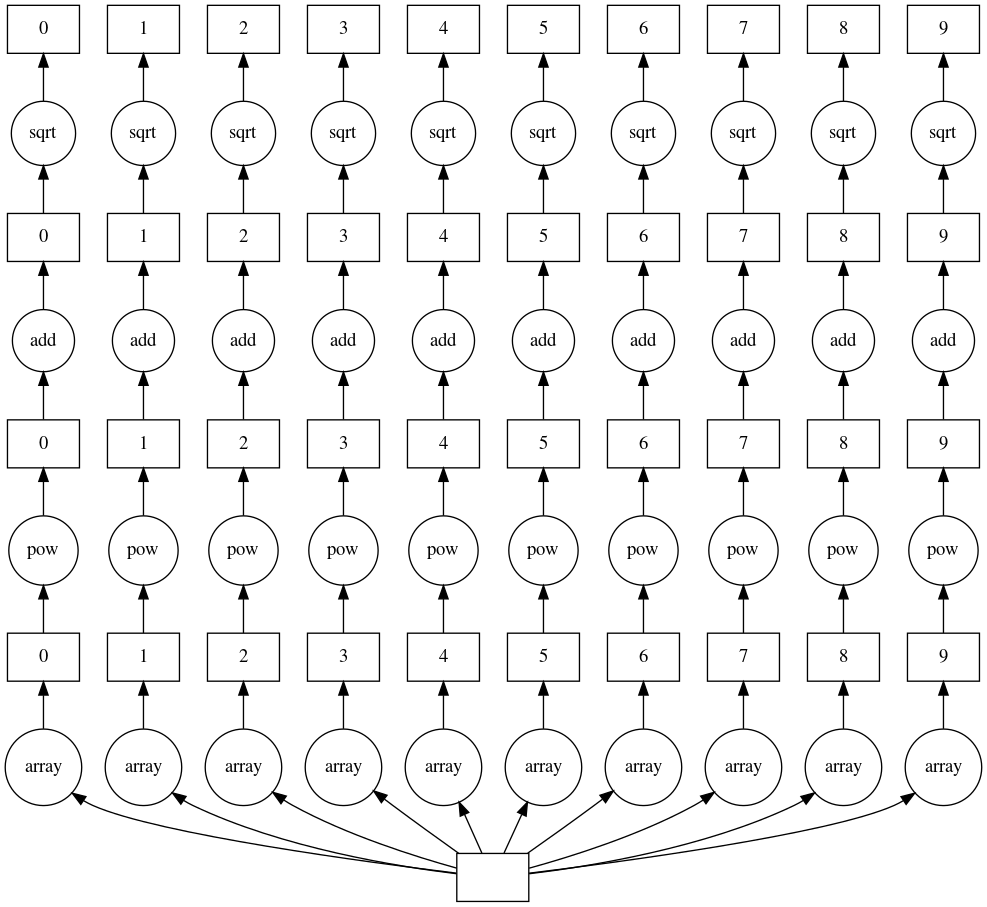

In [28]:
# What is "outarray"? It's a description of work to be done.

outarray.visualize()

In [29]:
# dask-schedulers and dask-workers could be running remotely...

os.system(r"dask-scheduler &")
os.system(r"dask-worker --nthreads 8 127.0.0.1:8786 &")

0

In [30]:
import dask.distributed

maybe_remote = dask.distributed.Client("127.0.0.1:8786")
maybe_remote

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [31]:
# Now we can run those same array operations anywhere, distributed by its "chunks."

outarray.compute(scheduler=maybe_remote)

array([0.00000000e+00, 1.41421356e+00, 2.82842712e+00, ...,
       1.41420932e+06, 1.41421073e+06, 1.41421215e+06])

In [32]:
!killall dask-scheduler dask-worker

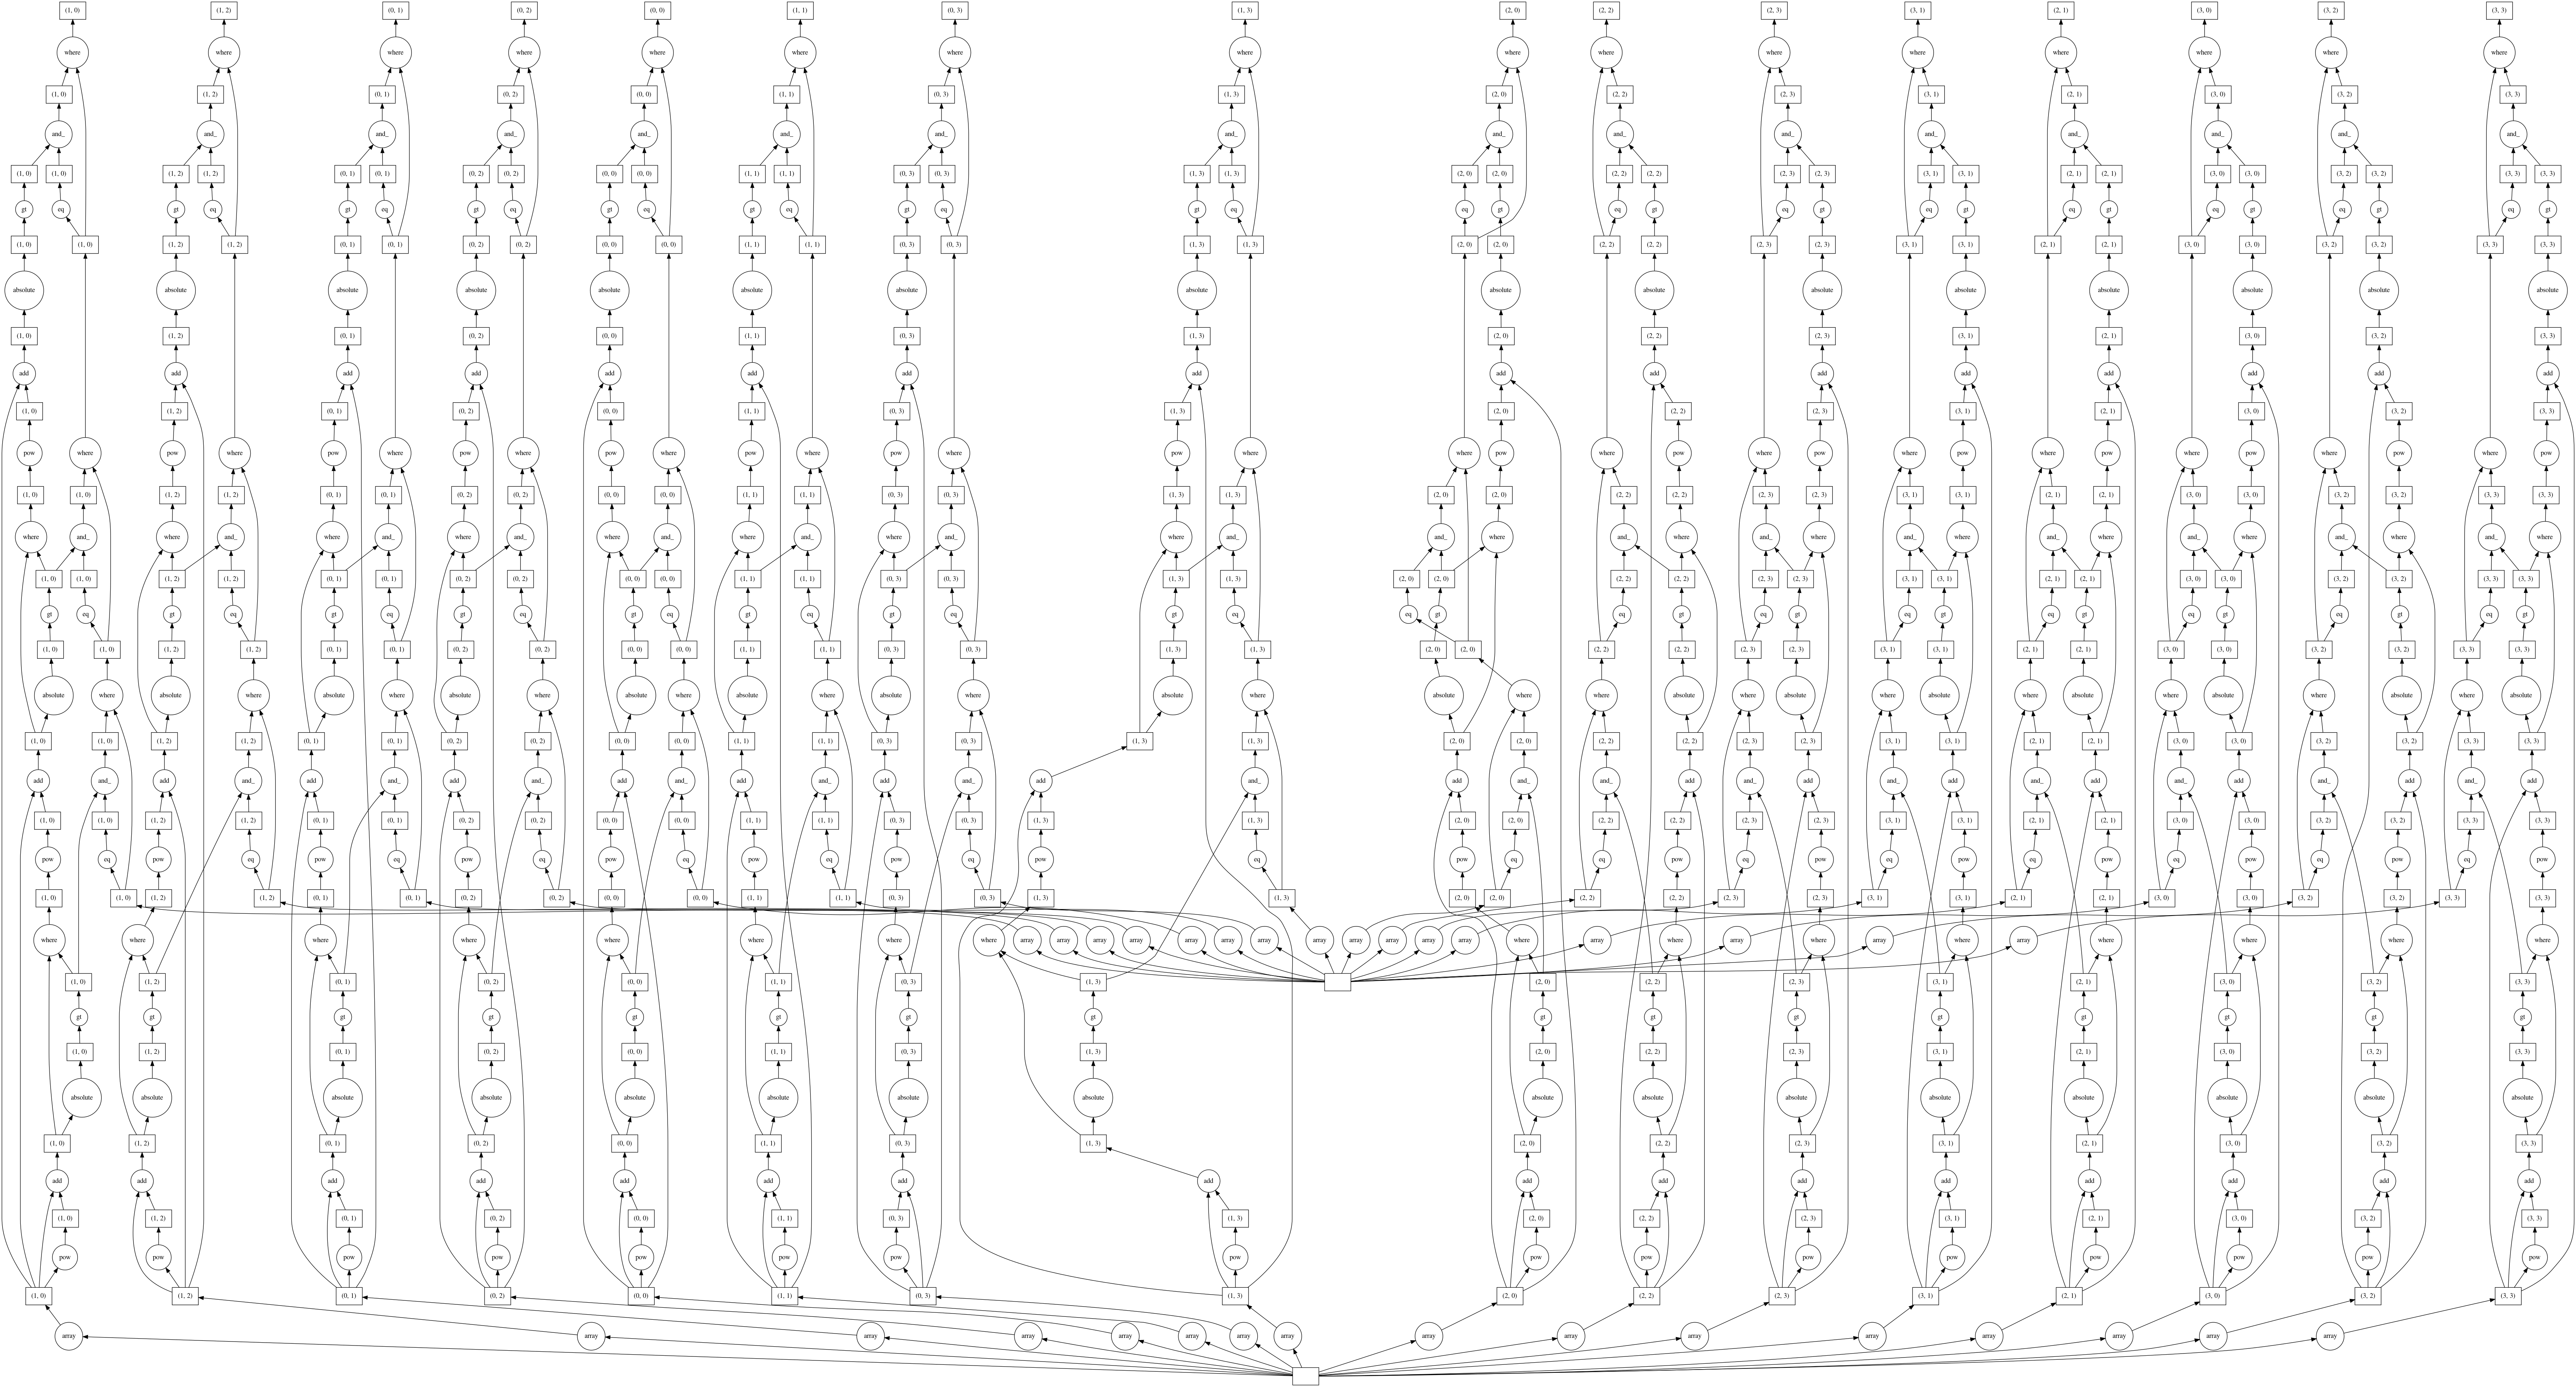

In [33]:
# The problem with Dask... do you remember the "compute a fractal" example?

def run_dask(height, width, maxiterations=20, hchunks=3, vchunks=4):
    chunked = lambda a: dask.array.from_array(a, chunks=(height // hchunks, width // vchunks))
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = chunked(x + y*1j)
    fractal = chunked(numpy.full(c.shape, maxiterations, dtype=numpy.int32))
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

run_dask(1600, 2400, maxiterations=3, hchunks=3, vchunks=4).visualize()

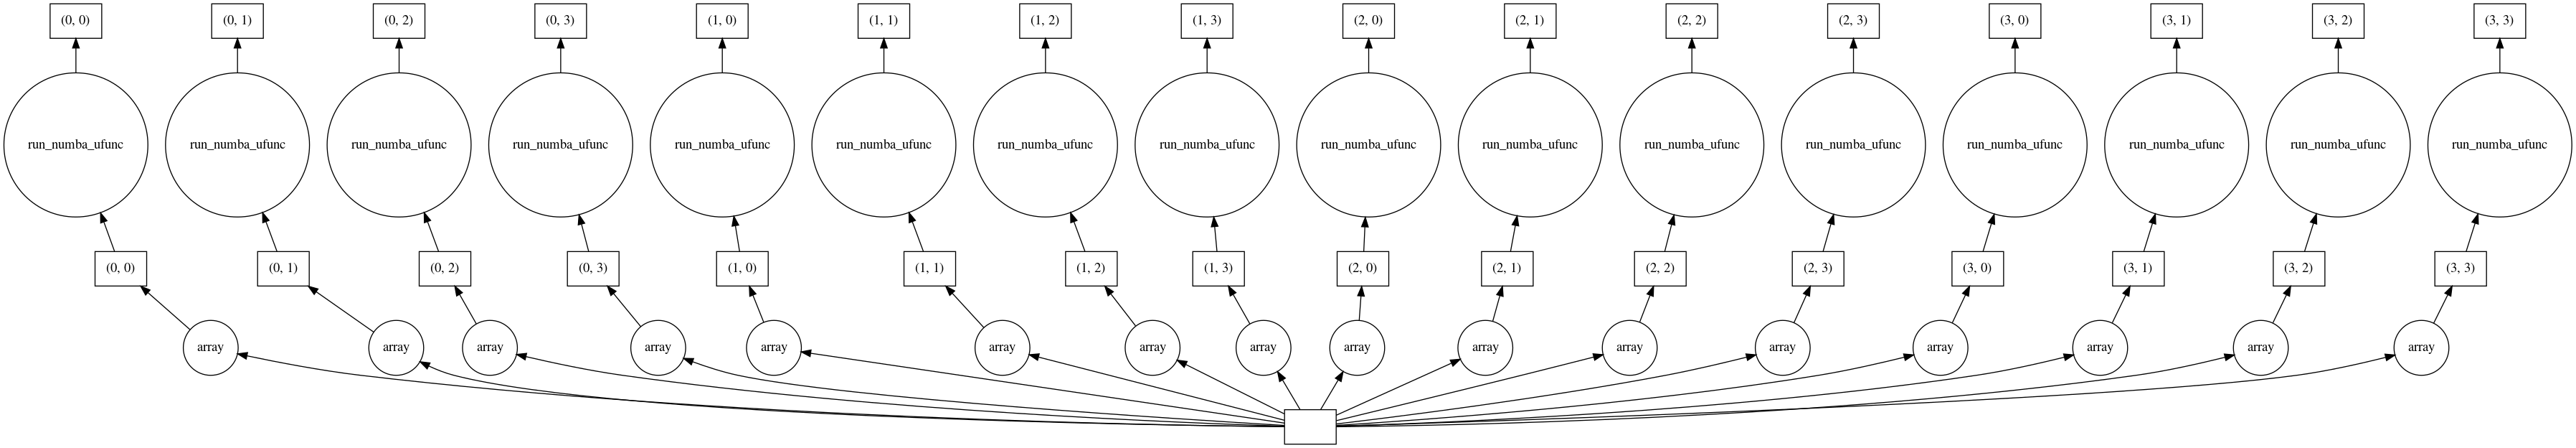

In [34]:
# There are too many little tasks!
# 
# Numba is not only good for compiling a complex function, it can also combine
# operations to hide them from Dask, simplifying the graph.

# Make a Numpy ufunc...
@numba.vectorize([numba.int32(numba.complex128, numba.int32)])
def run_numba_ufunc(c, maxiterations):
    z = c
    for i in range(maxiterations):
        z = z**2 + c
        if abs(z) > 2:
            return i
    return maxiterations

# Dask recognizes Numpy ufuncs...
def run_dask_numba(height, width, maxiterations=20, hchunks=3, vchunks=4):
    chunked = lambda a: dask.array.from_array(a, chunks=(height // hchunks, width // vchunks))
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    return run_numba_ufunc(chunked(x + y*1j), maxiterations)

run_dask_numba(1600, 2400, maxiterations=20, hchunks=3, vchunks=4).visualize()

<br><br><br><br><br>

<p style="font-size: 1.25em">This is a good example of two libraries not explicitly talking to each other, but both speaking the common language of Numpy ufuncs.</p>

<br><br><br><br><br>

<p style="font-size: 1.25em">Applying all the acceleration methods to the same <a href="misc-fractal.ipynb">fractal example</a>:</p>

| Method                                     | time (ns/px) | speedup |
|:-------------------------------------------|-------------:|--------:|
| Pure Python                                        | 12000   |    1× |
| Vectorized Numpy                                   |   368   |   30× |
| Vectorized CuPy (run on GPU)                       |    81   |  150× |
| Compiled by Numba                                  |   136   |   90× |
| Compiled & parallelized by Numba                   |    45   |  250× |
| Compiled & run on GPU by Numba                     |     7.8 | 1500× |
| Parallelized by Dask                               |   238   |   50× |
| Parallelized by Dask, compiled by Numba            |    48   |  250× |
| Partially rewritten in Cython (Python/C++ hybrid)  |  1485   |    8× |
| Completely rewritten in Cython (pure C++)          |    99   |  120× |
| Completely rewritten in pybind11 (pure C++)        |    98   |  120× |
| Completely rewritten in ROOT (pure C++ with `-O0`) |   379   |   32× |

<br><br><br><br><br>

### Multithreading/multiprocessing

<br><br><br><br><br>

In [35]:
import threading                 # part of Python

class Minion(threading.Thread):
    def __init__(self, i, j, xarray, yarray, outarray):
        super(Minion, self).__init__()
        self.i, self.j = i, j
        self.xarray, self.yarray, self.outarray = xarray, yarray, outarray

    def run(self):
        i, j, outarray = self.i, self.j, self.outarray
        outarray[i:j] = numpy.sqrt(self.xarray[i:j]**2 + self.yarray[i:j]**2)

xarray = numpy.arange(1000000, dtype=numpy.float64)
yarray = numpy.arange(1000000, dtype=numpy.float64)
outarray = numpy.empty(1000000, dtype=numpy.float64)

minions = []
for i, j in zip(range(0, 10), range(1, 10+1)):
    minions.append(Minion(i*100000, j*100000, xarray, yarray, outarray))

for minion in minions: minion.start()    # start all the threads
for minion in minions: minion.join()     # wait for all the threads to finish

outarray

array([0.00000000e+00, 1.41421356e+00, 2.82842712e+00, ...,
       1.41420932e+06, 1.41421073e+06, 1.41421215e+06])

In [37]:
import multiprocessing, ctypes   # part of Python

class Minion(multiprocessing.Process):
    def __init__(self, i, j, xarray, yarray, outarray):
        super(Minion, self).__init__()
        self.i, self.j = i, j
        self.xarray, self.yarray, self.outarray = xarray, yarray, outarray

    def run(self):
        i, j, outarray = self.i, self.j, numpy.frombuffer(self.outarray, numpy.float64)
        outarray[i:j] = numpy.sqrt(self.xarray[i:j]**2 + self.yarray[i:j]**2)

xarray = numpy.arange(1000000, dtype=numpy.float64)
yarray = numpy.arange(1000000, dtype=numpy.float64)
outarray = multiprocessing.RawArray(ctypes.c_double, 1000000)  # shared memory!

minions = []
for i, j in zip(range(0, 10), range(1, 10+1)):
    minions.append(Minion(i*100000, j*100000, xarray, yarray, outarray))

for minion in minions: minion.start()    # start all the threads
for minion in minions: minion.join()     # wait for all the threads to finish

numpy.frombuffer(outarray, dtype=numpy.float64)

array([0.00000000e+00, 1.41421356e+00, 2.82842712e+00, ...,
       1.41420932e+06, 1.41421073e+06, 1.41421215e+06])

<br><br><br>

<p style="font-size: 1.25em">Why separate processes? Look up "Global Interpreter Lock" (GIL).</p>

<br>

<p style="font-size: 1.25em">Short story: a single Python process can be <i>concurrent</i>, but not <i>parallel</i>.</p>

<br>

(Longer story: compiled code like Numpy and Numba can release the GIL and truly run in parallel, but Python operations on the same arrays can act as a _barrier_. Only independent Python processes are completely unconstrained.)

<br><br><br>

<br><br><br>

<center><img src="img/coffea-logo.png" width="25%"></center>

<br>

<p style="font-size: 1.25em; text-align: center; margin-left: 0px; margin-right: 0px; padding-left: 0px; padding-right: 0px">Coffea is a suite of Python tools for particle physics, including parallelization.</p>

<br><br><br>

Processing: 100%|██████████| 1/1 [00:01<00:00,  1.00s/items]


(<Figure size 432x288 with 1 Axes>,
 {None: [<matplotlib.lines.Line2D at 0x7a9ad0361080>,
   <ErrorbarContainer object of 3 artists>]})

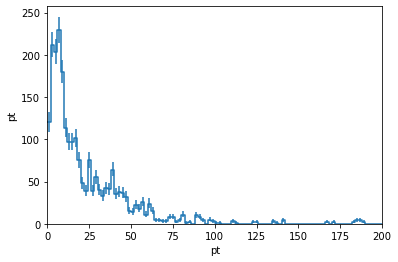

In [38]:
import coffea.hist
import coffea.processor

class Minion(coffea.processor.ProcessorABC):
    def __init__(self):
        self.histograms = coffea.processor.dict_accumulator(dict(
            pt = coffea.hist.Hist("pt", coffea.hist.Bin("pt", "pt", 100, 0, 200)),
            m = coffea.hist.Hist("m", coffea.hist.Bin("m", "m", 100, 0, 200))
        ))
    @property
    def accumulator(self):
        return self.histograms
    def process(self, df):
        out = self.accumulator.identity()
        out["pt"].fill(pt=numpy.sqrt((df["px1"] + df["px2"])**2 + (df["py1"] + df["py2"])**2))
        out["m"].fill(m=df["M"])
        return out
    def postprocess(self, accumulator):
        return accumulator

out = coffea.processor.run_uproot_job({"signal": ["data/Zmumu.root"]},
    treename="events", processor_instance=Minion(), executor=coffea.processor.futures_executor)

%matplotlib inline
coffea.hist.plot1d(out["pt"])

In [39]:
[x for x in dir(coffea.processor) if x.startswith("run_")]

['run_parsl_job', 'run_spark_job', 'run_uproot_job']